# Preamble
Import CASA and other necessary bits for this workbook. You can safely ignore the intricacies of the following cell

In [1]:
import sys
import os
import shutil
from IPython.display import display
import ipywidgets as widgets
import tempfile
from casatools import table
tb = table()
import numpy as np
from casatools import quanta
quanta = quanta()
import pyvirtualdisplay
from datetime import datetime
from datetime import timezone
from matplotlib import pyplot as plt

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

assert os.getenv('DISPLAY') != "" and os.getenv('DISPLAY') is not None
print('X11 Virtual Frame Buffer startup completed')

from casatasks import casalog
currentlogpos = 0
def runcasa(f, *args, **kwargs):
  """
    Runs a CASA task and prints the log
    Args:
      f: task method
      *args: positional arguments to the task f
      **kwargs: named arguments to the task f
    Returns the return value of f or None if failed
  """
  global currentlogpos
  if not os.path.exists(casalog.logfile()):
    with open(casalog.logfile(), "w+") as casalogfile:
      pass
  with open(casalog.logfile(), "r") as casalogfile:
    casalogfile.seek(currentlogpos)
    try:
      res = f(*args, **kwargs)
    finally:
      print(casalogfile.read())
      currentlogpos = casalogfile.tell()
  return res

# define the tasks on the current stack
# and wrap them inside a logger reader
import casatasks
import casatools
import casaplotms
from IPython.display import Image

def wrap_task(mod, tasks):
  for task in tasks:
    def logclosure(task):
      return lambda *args, **kwargs: runcasa(getattr(mod, task),
                                             *args,
                                             **kwargs)
    setattr(sys.modules[__name__], 
        task,
        logclosure(task))
    getattr(sys.modules[__name__], task).__doc__ = \
      getattr(mod, task).__doc__

wrap_task(casatools, ['agentflagger','atcafiller','atmosphere','calanalysis',
                      'calibrater','casadata','coercetype','componentlist',
                      'coordsys','ctsys','ctuser','errors','image','imagemetadata',
                      'imagepol','imager','iterbotsink','linearmosaic','logsink',
                      'measures','miriadfiller','ms','msmetadata','mstransformer',
                      'quanta','regionmanager','sakura','sdm',
                      'sidebandseparator','simulator','singledishms','spectralline',
                      'synthesisdeconvolver','synthesisimager','synthesisimstore',
                      'synthesismaskhandler','synthesisnormalizer','synthesisutils',
                      'table','typecheck','utils','version','version_string',
                      'vlafiller','vpmanager'])

wrap_task(casatasks, ['accor','apparentsens','applycal',
                      'asdmsummary','bandpass',
                      'blcal','calstat',
                      'clearcal',
                      'clearstat','concat','config',
                      'conjugatevis','cvel','cvel2',
                      'delmod','exportasdm','exportfits',
                      'exportuvfits','feather','fixplanets',
                      'fixvis','flagcmd','flagdata','flagmanager',
                      'fluxscale','fringefit','ft','gaincal',
                      'gencal','hanningsmooth','imcollapse',
                      'imcontsub','imdev','imfit','imhead',
                      'imhistory','immath','immoments','impbcor','importasap',
                      'importasdm','importatca','importfits','importfitsidi','importgmrt',
                      'importlib','importmiriad','importnro','importuvfits','importvla',
                      'impv','imrebin','imreframe','imregrid','imsmooth','imstat',
                      'imsubimage','imtrans','imval','initweights','listcal',
                      'listfits','listhistory','listobs','listpartition','listsdm',
                      'listvis','makemask','mstransform','nrobeamaverage',
                      'partition','plotants','plotbandpass','plotprofilemap',
                      'plotweather','polcal','polfromgain','predictcomp','rerefant',
                      'rmfit','rmtables','sdatmcor','sdbaseline','sdcal',
                      'sdfit','sdfixscan','sdgaincal','sdimaging','sdintimaging',
                      'sdpolaverage','sdsidebandsplit','sdsmooth','sdtimeaverage',          
                      'setjy','simalma','simanalyze','simobserve','slsearch','smoothcal',
                      'specfit','specflux','specsmooth','splattotable','split',
                      'spxfit','statwt','tclean','testconcat','tsdimaging','uvcontsub',
                      'uvmodelfit','uvsub','virtualconcat','vishead',
                      'visstat','widebandpbcor'])
wrap_task(casaplotms, ["plotms"])
print('CASA import and initialization completed')

X11 Virtual Frame Buffer startup completed
CASA import and initialization completed


# Data formats - exploring the Measurement Set specification
TART data and associated metadata can be downloaded in JSON and HDF5 format via the API and S3 bucket services. However, this data is not in a format that is immediately usable by standard calibration, flagging and imaging tooling used in practice. We convert the TART format data into an interchange relational schema called the Measurement Set [CASA memo 229](https://casa.nrao.edu/Memos/229.html) which is backed by the Casacore table system. The table system is employed by most large observatories, so it is worth spending some time getting more familiar with data in this format. 

The core relationships are shown below.

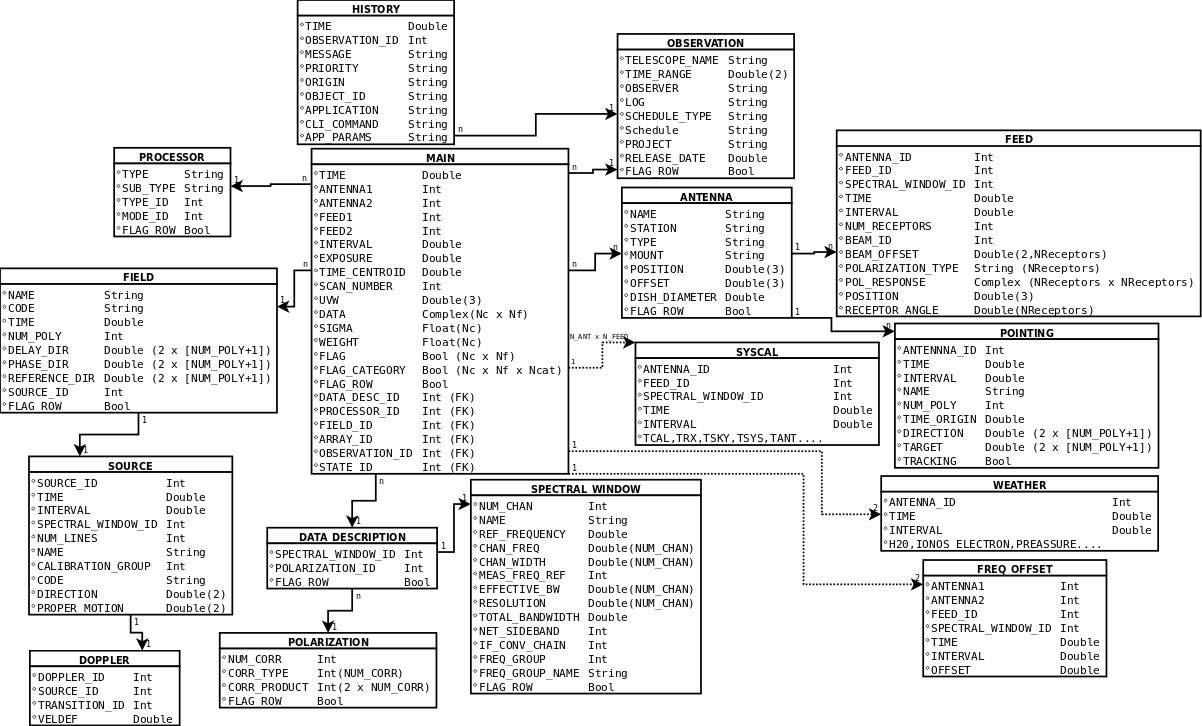

In [2]:
Image(os.path.join(os.path.abspath(""), "imgs", "ms_relations.png"))

Here the *MAIN* table contains the visibility data for all baselines and time, as well as the associated flags and weights - each row in the *Main* table therefore corresponds to a a baseline (defined by the antenna1 and antenna2 index) at a specific time and sub-band (or 'spectral window'). The indexes for the various metadata (field id, antenna1, antenna2, etc.) are linked to various *keyword tables* (based on row index, starting at 0).

Let's take a look at the example dataset we will be using for this practical. You can always roll back by activating the following cell. 

<span style="color:red">!!! Warning: this will erase any modifications you have made / calibrations applied to the dataset since you've run this cell !!!</span>

In [3]:
archive_fn = os.path.join(os.path.abspath(""), "tart.2022.11.22.10-12utc.pp.ms.tar.gz")
MSNAME = os.path.join(os.path.abspath(""), 'tart.ms')
OVERWRITE=False # true if you want to overwrite
##################################
##################################
##################################
if not os.path.exists(archive_fn):
    raise RuntimeError(f"Failed to find archive '{archive_fn}'. Check your git clone")
if OVERWRITE and os.path.exists(MSNAME):
    shutil.rmtree(MSNAME)
if OVERWRITE:
    !tar xvf {archive_fn}
assert os.path.exists(MSNAME)

We can open one of the keyword tables by appending the keyword table name to the measurement set path using the :: notation. For example opening the ANTENNA keyword table can be done as follows

In [4]:
tb.open("tart.ms::ANTENNA")
print(",".join(tb.getcol("NAME")))
tb.close()

ANTENNA-0,ANTENNA-1,ANTENNA-2,ANTENNA-3,ANTENNA-4,ANTENNA-5,ANTENNA-6,ANTENNA-7,ANTENNA-8,ANTENNA-9,ANTENNA-10,ANTENNA-11,ANTENNA-12,ANTENNA-13,ANTENNA-14,ANTENNA-15,ANTENNA-16,ANTENNA-17,ANTENNA-18,ANTENNA-19,ANTENNA-20,ANTENNA-21,ANTENNA-22,ANTENNA-23


True

Let us look at a few concrete examples on pulling information from the various tables. The data columns in the main table (DATA - usually raw, CORRECTED_DATA - usually calibrated to some level and MODEL_DATA which stores the model to which CORRECTED_DATA is calibrated (by least squares). Each of these columns contain #row x #channel x #feed correlation products for a specific spectral window and sub-observation (linked via the DDID index column and OBSERVATION_ID columns). These are just the regular columns, of which CORRECTED_DATA and MODEL_DATA is optional. The user can store data into arbitrary-named columns into the database.

There is only one observation and one spectral window in this dataset, so the number of rows is therefore #baselines x #time exposures, where the number of baselines is given as
\begin{equation}
\frac{N_\text{antenna}(N_\text{antenna} - 1)}{2}
\end{equation}

Let us start by checking this and querying the bandwidth and total observation exposure

In [5]:
tb.open(MSNAME+"::ANTENNA")
anames = tb.getcol("NAME")
nbl = len(anames)*(len(anames) - 1) // 2 # auto correlations not stored
print(f"{len(anames)} antennas in this database: {','.join(anames)} ({nbl} unique cross correlation baselines)")
tb.close()
tb.open(MSNAME+"::SPECTRAL_WINDOW")
ctr_freqs = tb.getcol("CHAN_FREQ")
chan_bandwidth = tb.getcol("CHAN_WIDTH")
print(f"{tb.nrows()} Spectral windows in this database")
for spw, (nu, bw) in enumerate(zip(ctr_freqs, chan_bandwidth)):
    print(f"\tSPW {spw}: {','.join(map(lambda x: f'{x:.2f}', nu*1e-6))} MHz with bandwidth(s) {','.join(map(lambda x: f'{x:.2f}', bw*1e-6))} MHz")
tb.close()

tb.open(MSNAME)
times = np.unique(tb.getcol("TIME"))

def __toutcdatetime(t):
    sd = quanta().splitdate(quanta().quantity(t, "s"))
    return datetime(year=sd['year'], month=sd['month'], day=sd['monthday'], 
                    hour=sd['hour'], minute=sd['min'], second=sd['sec']).replace(tzinfo=timezone.utc)
                    
print(f"There are {tb.nrows()} rows in this database. Start time {__toutcdatetime(times.min()).isoformat()}, "
      f"end time {__toutcdatetime(times.max()).isoformat()}")
assert tb.nrows() == nbl * times.size
tb.close()


24 antennas in this database: ANTENNA-0,ANTENNA-1,ANTENNA-2,ANTENNA-3,ANTENNA-4,ANTENNA-5,ANTENNA-6,ANTENNA-7,ANTENNA-8,ANTENNA-9,ANTENNA-10,ANTENNA-11,ANTENNA-12,ANTENNA-13,ANTENNA-14,ANTENNA-15,ANTENNA-16,ANTENNA-17,ANTENNA-18,ANTENNA-19,ANTENNA-20,ANTENNA-21,ANTENNA-22,ANTENNA-23 (276 unique cross correlation baselines)
1 Spectral windows in this database
	SPW 0: 1575.42 MHz with bandwidth(s) 2.50 MHz
2023-10-09 19:57:19	INFO	::casa	
2023-10-09 19:57:19	INFO	::casa	
2023-10-09 19:57:20	INFO	::casa	
2023-10-09 19:57:20	INFO	::casa	
2023-10-09 19:57:21	INFO	::casa	Python version 3.8.10
2023-10-09 19:57:21	INFO	::casa	CASA Version MODULAR 6.5.6.22
2023-10-09 19:57:21	INFO	::casa	Can't import casatelemetry module.




There are 1888116 rows in this database. Start time 2022-11-22T10:00:00+00:00, end time 2022-11-22T11:58:58+00:00


True

The $uvw$ coordinates are only scaled to the observing wavelength during imaging to conserve space. If the user queries the column descriptor for the $uvw$ column it is clear the three axes are stored in meters.

In [6]:
tb.open("tart.ms")
print(tb.nrows())
uvw = tb.getcol('UVW').T
print(uvw.shape)
uvdist = np.sqrt(np.sum(uvw**2, axis=1))
print('max uv:', np.max(uvdist), 'm')
print('min uv:', np.min(uvdist), 'm')
print(tb.getcoldesc("UVW"))
tb.close()

1888116
(1888116, 3)
max uv: 4.152744615333582 m
min uv: 0.11749276096662753 m
{'comment': 'Vector with uvw coordinates (in meters)', 'dataManagerGroup': 'UVW_GROUP', 'dataManagerType': 'TiledColumnStMan', 'keywords': {'MEASINFO': {'Ref': 'ITRF', 'type': 'uvw'}, 'QuantumUnits': array(['m', 'm', 'm'], dtype='<U1')}, 'maxlen': 0, 'ndim': 1, 'option': 5, 'shape': array([3]), 'valueType': 'double'}


True

The table format also supports a domain-specific query language that is very similar to the SQL query language used in relational databases. The syntax for this TaQL language is further discussed in
[Note 199](https://casacore.github.io/casacore-notes/199.html)

In [7]:
tb.open('tart.ms')
print(f"Number of rows in MAIN table {tb.nrows()}")
ttsel = tb.taql("select * from tart.ms where mscal.baseline('1m~2m')")
print(f"Number of rows in selection {ttsel.nrows()}")
print("Max spacing in selection:", np.max(np.sqrt(np.sum(ttsel.getcol("UVW").T**2, axis=1))))
print("Min spacing in selection:", np.min(np.sqrt(np.sum(ttsel.getcol("UVW").T**2, axis=1))))
tb.close()

tb.open('tart.ms')
print(f"Number of rows in MAIN table {tb.nrows()}")
ttsel = tb.taql("SELECT FROM tart.ms WHERE ANTENNA1 IN [SELECT ROWID() FROM ::ANTENNA WHERE NAME ~ p/ANTENNA-[123]/]")
print(f"Number of rows in selection {ttsel.nrows()}")
tb.close()

Number of rows in MAIN table 1888116
Number of rows in selection 506234
Max spacing in selection: 1.9929591548332073
Min spacing in selection: 1.0000411437865007
Number of rows in MAIN table 1888116
Number of rows in selection 430983


True

## Practical
Use TaQL and Numpy to calculate the flagged percentages of the
1. Entire dataset
2. All baselines to a specified antenna